In [1]:
from __future__ import absolute_import, division
import glob
import os
import re
import json
from astropy.io import fits as fits
import matplotlib.dates as mdates
import h5py
import datetime
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
this_dir = os.getcwd()

import matplotlib as mpl
# try to use the precise epoch
mpl.rcParams['date.epoch']='1970-01-01T00:00:00'
try:
    mdates.set_epoch('1970-01-01T00:00:00')
except:
    pass

from tqdm import tqdm
%matplotlib inline

%load_ext autotime

time: 0 ns (started: 2022-07-03 23:30:44 +02:00)


In [2]:
os.getcwd()

'd:\\vult\\nacad\\2021_a\\LOFARdev\\lofar-sun-tools\\utils\\BF'

time: 0 ns (started: 2022-07-03 23:30:45 +02:00)


In [3]:
x_points = 900 # time sample points
y_points = -1 # f samples  (-1 for not down sampling, keep origional) 
chunk_t = datetime.timedelta(minutes=15)
chop_off = False # chop every **interger** 15 minutes [00:15,00:30,00:45....]

# IMORTANT!! give absolute (or relative) paths to the next array: first of the calibrator, and then of the target source
h5dirs = ['../h5testdata/cal/','../h5testdata/sun/']
out_dir_base = '../h5testdata/out/' # should be absolute dir starting from '/'
#calibrator_name = 'Cassiopeia A'
SAP_calibrator = '001'
SAP_target = '000'
work_dir = 'D:\\vult\\nacad\\2021_a\\LOFARdev\\lofar-sun-tools\\utils\\h5testdata'
#os.getcwd()

def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '#'):
    '''
    The process bar function.
    To see the process while processing
    '''
    percent = ('{0:.' + str(decimals) + 'f}').format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end ='\r')
    # Print New Line on Complete
    if iteration == total: 
        print()
        
        
def print_name(name):
    print(name)
#f.visit(print_name)


def read_file(fname):
    '''
    This function reads a typical LOFAR LBA fits file

    Input: the path+name of the file
    Output: the dynamic spectrum, frequencies vector and time vector
    '''
    hdu = fits.open(fname)
    dyspec = hdu[0].data
    f_fits = hdu[1].data['FREQ'][:]
    t_fits = hdu[2].data['TIME'][:]
    return dyspec,f_fits,t_fits
    
def model_flux(calibrator, frequency):
    '''
    Calculates the model matrix for flux calibration for a range of known calibrators:
    J0133-3629, 3C48, Fornax A, 3C 123, J0444+2809, 3C138, Pictor A, Taurus A, 3C147, 3C196, Hydra A, Virgo A, 
    3C286, 3C295, Hercules A, 3C353, 3C380, Cygnus A, 3C444, Cassiopeia A

    Input: the calibrator name, frequency range, and time range
    Output: the calibration matrix (in sfu)
    '''
    parameters = []

    Cal_dict = {'J0133-3629':[1.0440,-0.662,-0.225],
                '3C48': [1.3253,-0.7553,-0.1914,0.0498],
                'ForA': [2.218,-0.661],
                '3C123':[1.8017,-0.7884,-0.1035,-0.0248,0.0090],
                'J0444-2809':[0.9710,-0.894,-0.118],
                '3C138':[1.0088,-0.4981,-0.155,-0.010,0.022,],
                'PicA':[1.9380,-0.7470,-0.074],
                'TauA':[2.9516,-0.217,-0.047,-0.067],
                '3C247':[1.4516,-0.6961,-0.201,0.064,-0.046,0.029],
                '3C196':[1.2872,-0.8530,-0.153,-0.0200,0.0201],
                'HydA':[1.7795,-0.9176,-0.084,-0.0139,0.030],
                'VirA':[2.4466,-0.8116,-0.048],
                '3C286':[1.2481 ,-0.4507 ,-0.1798 ,0.0357 ],
                '3C295':[1.4701,-0.7658,-0.2780,-0.0347,0.0399],
                'HerA':[1.8298,-1.0247,-0.0951],
                '3C353':[1.8627,-0.6938,-0.100,-0.032],
                '3C380':[1.2320,-0.791,0.095,0.098,-0.18,-0.16],
                '3C444':[3.3498,-1.0022,-0.22,0.023,0.043],
                'CasA':[3.3584,-0.7518,-0.035,-0.071]}
    if calibrator in Cal_dict.keys():
        parameters = Cal_dict[calibrator]
    else:  raise ValueError(calibrator, "is not in the calibrators list")
        
    flux_model = 0
    frequency /= 10**3 # convert from MHz to GHz
    for j,p in enumerate(parameters):
        flux_model += p*np.log10(frequency)**j
    flux_model = 10**flux_model # because at first the flux is in log10
    return flux_model*10**(-4) #convert form Jy to sfu

def calibration_with_1bandpass(target_file, bandpass_calibrator, calibrator):
    '''
    Calibrates the target data using a calibrator

    Input: the target file, the calibrator file, the calibrator name.
    Output: the calibrated dynamic spectrum of the target source
    '''
    # read the data
    dyspec_target, f_fits_target, t_fits_target = read_file(target_file)
    
    # convert from dB to raw flux
    dyspec_target = 10**(dyspec_target/10)
    for i in range(f_fits_target.shape[0]):
        dyspec_target[:,i] = dyspec_target[:,i]/bandpass_calibrator[i]*model_flux(calibrator, f_fits_target[i])
    return dyspec_target, f_fits_target, t_fits_target # the calibrated image in sfu, its frequency and time range

def partition_avg(arr, ratio_range):
    
    #  average in a given ratio range to exclude extreme value
    
    arr_sort = np.sort(arr.ravel())
    nums = arr_sort[int(ratio_range[0]*arr_sort.shape[0]):int(ratio_range[1]*arr_sort.shape[0])]
    return np.mean(nums)


time: 16 ms (started: 2022-07-03 23:30:46 +02:00)


In [4]:
def get_cal_bandpass(freq_idx, h5dir, h5name,ratio_range=[0.2,0.8]):
    fname_DS=h5name
    this_dir = os.getcwd()
    os.chdir(h5dir)
    m = re.search('B[0-9]{3}', fname_DS)
    beam_this = m.group(0)[1:4]
    m = re.search('SAP[0-9]{3}', fname_DS)
    SAP = m.group(0)[3:6]

    f = h5py.File( fname_DS, 'r' )
    data_shape = f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'].shape
    
    if data_shape[0]>1e3:
        sampling=int(data_shape[0]/1e3)
    else:
        sampling=1
    
    bandpass_cal=[]
    for this_freq_idx in tqdm(freq_idx,ascii=True,desc='Bulding Cal-bandpass'):
        data_lightcurve_cal=f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][::sampling,this_freq_idx]
        bandpass_cal.append(partition_avg(data_lightcurve_cal,ratio_range))
    
    os.chdir(this_dir)
    return bandpass_cal

time: 16 ms (started: 2022-07-03 23:30:49 +02:00)


In [5]:
# cal
os.chdir(work_dir) # go back home
h5dir='../h5testdata/cal/'
fname_DS='L863010_SAP001_B000_S0_P000_bf.h5'
print(h5dir,fname_DS)

../h5testdata/cal/ L863010_SAP001_B000_S0_P000_bf.h5
time: 0 ns (started: 2022-07-03 23:30:55 +02:00)


In [6]:
os.chdir(work_dir) # go back home
os.chdir(h5dir)
m = re.search('B[0-9]{3}', fname_DS)
m.group(0)
beam_this = m.group(0)[1:4]
m = re.search('SAP[0-9]{3}', fname_DS)
m.group(0)
SAP = m.group(0)[3:6]

f = h5py.File( fname_DS, 'r' )
group = f['/']
        #keys = sorted(['%s'%item for item in sorted(list(group.attrs))])
        
        # obtain name of calibrator
target_obs = group.attrs['TARGETS']
calibrator_name = [x for x in target_obs if x!='Sun'][0]
        
data_shape = f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'].shape
data_lightcurve_cal=f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][:,600]

time: 34.1 s (started: 2022-07-03 23:31:00 +02:00)


In [7]:
data_shape

(337600, 960)

time: 0 ns (started: 2022-07-03 23:31:54 +02:00)


In [7]:
# sun
os.chdir(work_dir) # go back home
h5dir='../h5testdata/sun/'
fname_DS='L863010_SAP000_B000_S0_P000_bf.h5'
print(h5dir,fname_DS)

../h5testdata/sun/ L863010_SAP000_B000_S0_P000_bf.h5
time: 0 ns (started: 2022-06-12 17:19:06 +02:00)


In [8]:
os.chdir(work_dir) # go back home
os.chdir(h5dir)
m = re.search('B[0-9]{3}', fname_DS)
m.group(0)
beam_this = m.group(0)[1:4]
m = re.search('SAP[0-9]{3}', fname_DS)
m.group(0)
SAP = m.group(0)[3:6]

f = h5py.File( fname_DS, 'r' )
group = f['/']
        #keys = sorted(['%s'%item for item in sorted(list(group.attrs))])
        
        # obtain name of calibrator
target_obs = group.attrs['TARGETS']
#calibrator_name = [x for x in target_obs if x!='Sun'][0]
        
data_shape = f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'].shape

time: 0 ns (started: 2022-06-12 17:19:07 +02:00)


In [9]:
data_lightcurve_sun=f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][:,600]

time: 31.1 s (started: 2022-06-12 17:19:09 +02:00)


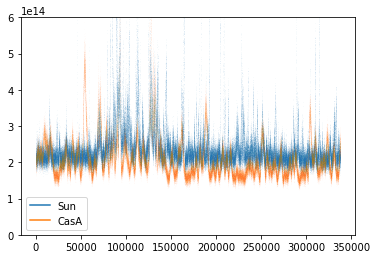

time: 1.03 s (started: 2022-06-12 17:19:43 +02:00)


In [10]:
plt.plot(data_lightcurve_sun,'.',ms=0.02)
plt.plot(data_lightcurve_cal,'.',ms=0.01)
plt.ylim([0.0e14,6e14])
l1, =plt.plot([],[],'C0')
l2, =plt.plot([],[],'C1')
plt.legend([l1,l2],['Sun','CasA'])

In [11]:
# calibrator fluctuate intensively

time: 16 ms (started: 2022-06-12 17:19:46 +02:00)


In [11]:
f['/'].attrs['TOTAL_INTEGRATION_TIME']

3539.992576

time: 0 ns (started: 2022-07-03 23:35:40 +02:00)


In [14]:

h5dir='../h5testdata/sun/'

# convert h5 to fits for both the source and the calibrator
for h5dir in [h5dir]:
    os.chdir(work_dir) # go back home
    os.chdir(h5dir)  # the dir contains the h5
    out_dir_base_local = 'Sun_fits'
    SAP = SAP_target

    for fname_DS in glob.glob('./*.h5'):
        
        m = re.search('B[0-9]{3}', fname_DS)
        m.group(0)
        beam_this = m.group(0)[1:4]

        f = h5py.File( fname_DS, 'r' )
        group = f['/']
        #keys = sorted(['%s'%item for item in sorted(list(group.attrs))])
        
        # obtain name of calibrator
        target_obs = group.attrs['TARGETS']
        calibrator_name = [x for x in target_obs if x!='Sun'][0]
        
        data_shape = f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'].shape

        # get shape of the BF raw
        t_lines = data_shape[0]
        f_lines = data_shape[1]

        # get the time parameters
        tsamp = f['/SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/COORDINATES/COORDINATE_0'].attrs['INCREMENT']
        tint = f['/'].attrs['TOTAL_INTEGRATION_TIME']


        t_start_bf = datetime.datetime.strptime(group.attrs['OBSERVATION_START_UTC'][0:26]+' +0000',
                                                '%Y-%m-%dT%H:%M:%S.%f %z')
        t_end_bf = datetime.datetime.strptime(group.attrs['OBSERVATION_END_UTC'][0:26]+' +0000',
                                                '%Y-%m-%dT%H:%M:%S.%f %z')
        
        out_dir = out_dir_base_local+fname_DS.split('/')[-1].split('.')[0]+'/'
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)


        # get the frequency axies
        freq = f['/SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/COORDINATES/COORDINATE_1'].attrs['AXIS_VALUES_WORLD']/1e6
        this_ra = f['/SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this].attrs['POINT_RA']
        this_dec = f['/SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this].attrs['POINT_DEC']

        if chop_off :
            t_start_chunk = mdates.num2date((np.ceil(mdates.date2num(t_start_bf)*24*4.))/4/24)
        else:
            t_start_chunk = t_start_bf

        chunk_num = ((t_end_bf-t_start_chunk)/chunk_t)

        if y_points>0:
            freq_select_idx = np.int32(np.linspace(0,f_lines-1,y_points))
        else:
            freq_select_idx = np.arange(f_lines)
        
        f_fits = freq[freq_select_idx]


        for idx_cur in np.arange(int(chunk_num)):
            printProgressBar(idx_cur + 1, int(chunk_num), prefix = 'Progress:', suffix = 'Complete', length = 50)

            # select the time
            t_start_fits = t_start_chunk + idx_cur*1.0*chunk_t
            t_end_fits  = t_start_chunk + (idx_cur+1)*1.0*chunk_t

            t_ratio_start = (mdates.date2num(t_start_fits) 
                            - mdates.date2num(t_start_bf)) / (mdates.date2num(t_end_bf)
                                                            - mdates.date2num(t_start_bf))
            idx_start = int(t_ratio_start*(t_lines-1))

            t_ratio_end  =   (mdates.date2num(t_end_fits) 
                            - mdates.date2num(t_start_bf)) / (mdates.date2num(t_end_bf)
                                                            - mdates.date2num(t_start_bf))
            idx_end = int(t_ratio_end*(t_lines-1))

            stokes = f['/SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][idx_start:idx_end:int((idx_end-idx_start)/x_points+1),:]
            stokes = np.abs(stokes) + 1e-7
            data_fits = 10.0*np.log10(stokes)[:,freq_select_idx]
            t_fits = np.linspace(mdates.date2num(t_start_fits),mdates.date2num(t_end_fits),data_fits.shape[0])

            hdu_lofar = fits.PrimaryHDU()
            hdu_lofar.data = data_fits
            hdu_lofar.header['SIMPLE']    =                    True          
            hdu_lofar.header['BITPIX']    =                    8 
            hdu_lofar.header['NAXIS ']    =                    2          
            hdu_lofar.header['NAXIS1']    =                 x_points          
            hdu_lofar.header['NAXIS2']    =                 y_points          
            hdu_lofar.header['EXTEND']    =                    True               
            hdu_lofar.header['DATE']      =  t_start_fits.strftime('%Y-%m-%d')         
            hdu_lofar.header['CONTENT']   =  t_start_fits.strftime('%Y/%m/%d') + ' Radio Flux Intensity LOFAR ' + group.attrs['ANTENNA_SET']
            hdu_lofar.header['ORIGIN']    = 'ASTRON Netherlands'
            hdu_lofar.header['TELESCOP']  =  group.attrs['TELESCOPE']
            hdu_lofar.header['INSTRUME']  =  group.attrs['ANTENNA_SET']          
            hdu_lofar.header['OBJECT']    =  group.attrs['TARGETS'][0]         
            hdu_lofar.header['DATE-OBS']  =  t_start_fits.strftime('%Y/%m/%d')         
            hdu_lofar.header['TIME-OBS']  =  t_start_fits.strftime('%H:%M:%S.%f')       
            hdu_lofar.header['DATE-END']  =  t_end_fits.strftime('%Y/%m/%d')         
            hdu_lofar.header['TIME-END']  =  t_end_fits.strftime('%H:%M:%S.%f')          
            hdu_lofar.header['BZERO']     =                   0. 
            hdu_lofar.header['BSCALE']    =                   1. 
            hdu_lofar.header['BUNIT']     = 'digits  '           
            hdu_lofar.header['DATAMIN']   =                  np.min(data_fits) 
            hdu_lofar.header['DATAMAX']   =                  np.max(data_fits) 
            hdu_lofar.header['CRVAL1']    =               74700. 
            hdu_lofar.header['CRPIX1']    =                    0 
            hdu_lofar.header['CTYPE1']    = 'Time [UT]'          
            hdu_lofar.header['CDELT1']    =                 0.25 
            hdu_lofar.header['CRVAL2']    =                 200. 
            hdu_lofar.header['CRPIX2']    =                    0 
            hdu_lofar.header['CTYPE2']    = 'Frequency [MHz]'    
            hdu_lofar.header['CDELT2']    =                  -1.  
            hdu_lofar.header['HISTORY']   = '        '      
            hdu_lofar.header['BEAM-RA']   = this_ra 
            hdu_lofar.header['BEAM-DEC']   = this_dec    


            col_freq = fits.Column(name='FREQ', format='D',array=f_fits)
            col_time = fits.Column(name='TIME', format='D',array=t_fits)
            
            hdu_f = fits.BinTableHDU.from_columns([col_freq],name="FREQ")
            hdu_t = fits.BinTableHDU.from_columns([col_time],name="TIME")

            fname = t_start_fits.strftime('LOFAR_%Y%m%d_%H%M%S_')+group.attrs['ANTENNA_SET']+'.fits'

            #full_hdu = fits.HDUList([hdu_lofar, hdu_lofar_axes])
            
            hdul = fits.HDUList([hdu_lofar,hdu_f,hdu_t])
            hdul.writeto(out_dir+fname,overwrite=True)
            fig = plt.figure(figsize=(6, 4), dpi=120)
            ax = plt.gca()

            
            bandpass_arr = [np.mean(tmp[np.where((tmp>np.sort(tmp)[int(0.03*tmp.shape[0])]) 
                        & (tmp<np.sort(tmp)[int(0.2*tmp.shape[0])]))])  for tmp in list(data_fits.T)]

            data_fits_new = data_fits-np.tile(np.mean(data_fits,0),(data_fits.shape[0],1))
            data_fits_new = data_fits-np.tile(bandpass_arr,(data_fits.shape[0],1))

            im = ax.imshow(data_fits_new.T,aspect='auto',  origin='lower', 
                    vmin=(np.mean(data_fits_new)-2*np.std(data_fits_new)),
                    vmax=(np.mean(data_fits_new)+3*np.std(data_fits_new)),
                    extent=[t_fits[0],t_fits[-1],f_fits[0],f_fits[-1]],cmap='inferno')

            ax.xaxis_date()
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
            ax.set_xlabel('Time (UT)')
            ax.set_ylabel('Frequency (MHz)')
            ax.set_title(hdu_lofar.header['CONTENT'])
            cbar = plt.colorbar(im)
            cbar.set_label('Power [dB]', rotation = 270, verticalalignment='baseline')
            fig.savefig(out_dir+fname.split('.')[0]+'.png')

            plt.figure()
            plt.plot(bandpass_arr)
            plt.gcf().savefig(out_dir+fname.split('.')[0]+'bandpass.png')

            lofar_json_dict = {}

            lofar_json_dict['telescope']= 'LOFAR'
            lofar_json_dict['instrume']  =  group.attrs['ANTENNA_SET']
            lofar_json_dict['projectID'] =  group.attrs['PROJECT_ID']
            lofar_json_dict['obsID'] =  group.attrs['OBSERVATION_ID']
            lofar_json_dict['source']=fname_DS
            lofar_json_dict['date']  = t_start_fits.strftime('%Y-%m-%d')
            lofar_json_dict['time']  =  t_start_fits.strftime('%H:%M:%S.%f')
            lofar_json_dict['event'] = {'detection': True ,'type':'III','level':'strong'}
            lofar_json_dict['n_freq']  = len(f_fits)
            lofar_json_dict['n_time']  = len(t_fits)
            lofar_json_dict['freq_range'] = [np.min(f_fits),np.max(f_fits)]
            lofar_json_dict['time_range'] = [t_start_fits.strftime('%Y-%m-%d %H:%M:%S.%f'),t_end_fits.strftime('%Y-%m-%d %H:%M:%S.%f')]


            #print(json.dumps(lofar_json_dict, indent=4, sort_keys=True))
            plt.close('all')
            with open(out_dir+fname.split('.')[0]+'.json', 'w') as fp:
                json.dump(lofar_json_dict, fp)

print('Calibrator:',calibrator_name)

# go back home
os.chdir(work_dir)

Progress: |##################################################| 100.0% Complete
Calibrator: CasA
time: 1.06 s (started: 2022-06-12 17:20:42 +02:00)


In [15]:
dyspec,f_fits,t_fits= read_file('../h5testdata/cal/calibrator_fits/LOFAR_20220602_101600_LBA_OUTER.fits')
dyspec,f_fits,t_fits= read_file('../h5testdata/sun/Sun_fits/LOFAR_20220602_101600_LBA_OUTER.fits')

time: 15 ms (started: 2022-06-12 17:20:45 +02:00)


In [16]:
raw_ds = 10**(dyspec/10.)

time: 16 ms (started: 2022-06-12 17:20:47 +02:00)


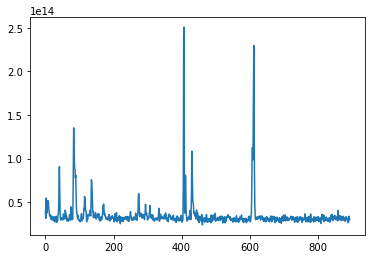

time: 63 ms (started: 2022-06-12 17:20:48 +02:00)


In [17]:
plt.plot(raw_ds[:,300])
plt.show()

In [18]:

os.chdir(work_dir) # go back home
h5dir='../h5testdata/cal/'
fname_DS='L863010_SAP001_B000_S0_P000_bf.h5'
print(h5dir,fname_DS)
bandpass_cal  =  get_cal_bandpass(freq_select_idx, h5dir, fname_DS, [0.4,0.6])

../h5testdata/cal/ L863010_SAP001_B000_S0_P000_bf.h5


Bulding Cal-bandpass: 100%|##########| 960/960 [00:49<00:00, 19.42it/s]

time: 49.4 s (started: 2022-06-12 17:20:50 +02:00)


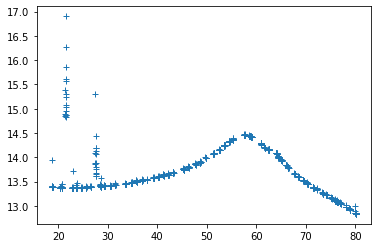

time: 94 ms (started: 2022-06-12 17:26:20 +02:00)


In [34]:
plt.plot(freq,np.log10(bandpass_cal),'+')

C:\Users\Pjer1\AppData\Local\Temp\ipykernel_67684\2960463870.py:38: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = ax.imshow((data_fits_new.T),aspect='auto',  origin='lower', vmin=1,vmax=100,


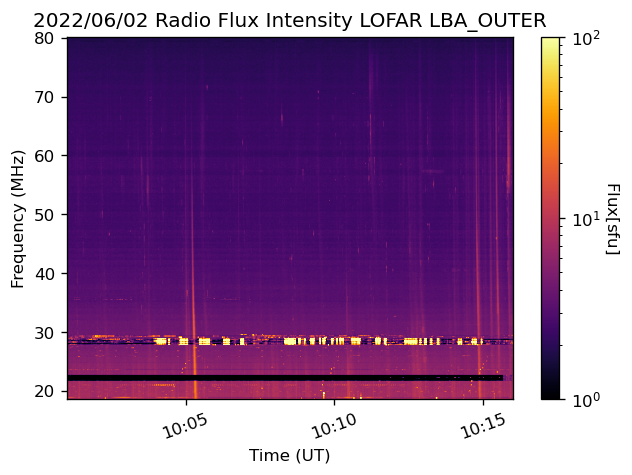

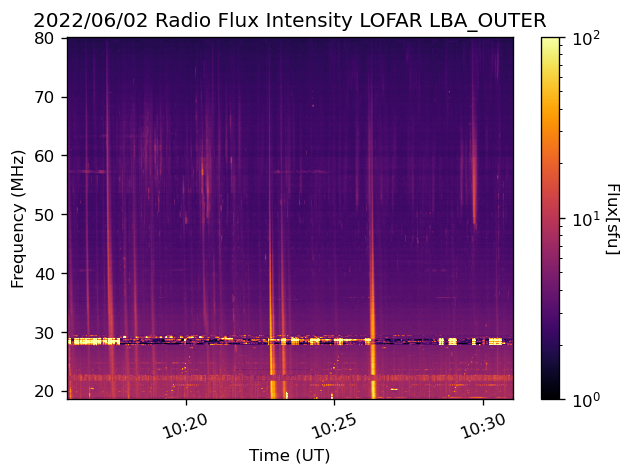

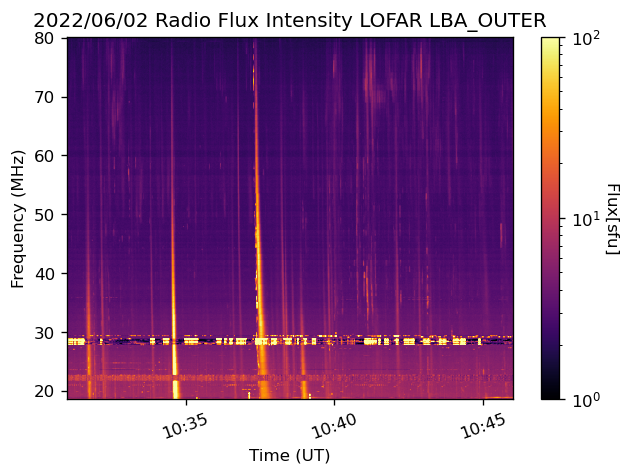

time: 1.94 s (started: 2022-06-12 17:21:49 +02:00)


In [20]:

# go back home
os.chdir(work_dir)
# save the name of the files
names_calibrator = []
names_sun = []
calibrator = True
for h5dir in h5dirs:
    if calibrator == True:
        for file in os.listdir(h5dir+'/calibrator_fits'):
            if file.endswith(".fits"):
                path_calibrator = h5dir+'/calibrator_fits/'
                names_calibrator.append(file)
        calibrator = False
    else: 
        for file in os.listdir(h5dir+'/Sun_fits'):
            if file.endswith(".fits"):
                path_sun = h5dir+'/Sun_fits/'
                names_sun.append(file)


# calibrate file by file
for i in range(len(names_calibrator)):
    
    data_calibrated, f_fits, t_fits = calibration_with_1bandpass(path_sun+names_sun[i],bandpass_cal,calibrator_name)
    
    hdu = fits.open(path_sun+names_sun[i])
    hdu[0].data = data_calibrated

    if not os.path.exists(out_dir_base):
        os.makedirs(out_dir_base)

    hdul.writeto(out_dir_base+names_sun[i],overwrite=True)

    fig = plt.figure(figsize=(6, 4), dpi=120)
    ax = plt.gca()
   
    data_fits_new = (data_calibrated)
    im = ax.imshow((data_fits_new.T),aspect='auto',  origin='lower', vmin=1,vmax=100,
            extent=[t_fits[0],t_fits[-1],f_fits[0],f_fits[-1]],cmap='inferno', norm=matplotlib.colors.LogNorm())

    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.setp(ax.get_xticklabels(), rotation=20, fontsize=10)
    ax.set_xlabel('Time (UT)')
    ax.set_ylabel('Frequency (MHz)')
    ax.set_title(hdu_lofar.header['CONTENT'])
    
    cbar = plt.colorbar(im, ax = ax)
    cbar.set_label(r'$\rm Flux [sfu]$', rotation = 270, verticalalignment='baseline')
    fig.savefig(out_dir_base+names_sun[i][:-5]+'.png')

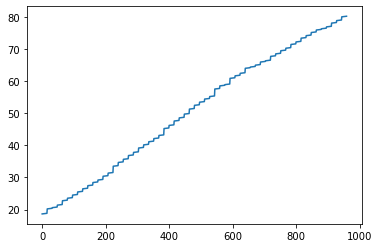

time: 62 ms (started: 2022-06-12 17:21:53 +02:00)


In [21]:
plt.plot(f_fits)
plt.show()

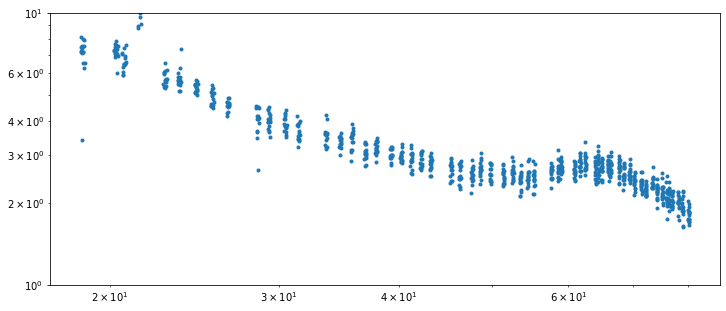

time: 297 ms (started: 2022-06-12 17:25:46 +02:00)


In [32]:
plt.figure(figsize=[12,5])
plt.plot(freq,data_calibrated[2,:],'.')
plt.ylim([1,10])
plt.yscale('log')
plt.xscale('log')